# Image Preprocessing

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import cv2
import os
from torchvision import transforms
import torch
import pickle
from random import shuffle
import imutils

In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torch import optim
%matplotlib inline

In [125]:
import operator
import cv2
import numpy as np
def pre_process_image(img, skip_dilate=False):
    """Uses a blurring function, adaptive thresholding and dilation to expose the main features of an image."""
    # Gaussian blur with a kernal size (height, width) of 9.
    # Note that kernal sizes must be positive and odd and the kernel must be square.
    proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)
    # Adaptive threshold using 11 nearest neighbour pixels
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    # Invert colours, so gridlines have non-zero pixel values.
    # Necessary to dilate the image, otherwise will look like erosion instead.
    proc = cv2.bitwise_not(proc, proc)
    #if not skip_dilate:
    #    # Dilate the image to increase the size of the grid lines.
    #    kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]])
    #    proc = cv2.dilate(proc, kernel)
    return proc
def find_corners_of_largest_polygon(img):
    """Finds the 4 extreme corners of the largest contour in the image."""
    contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image
    # Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
    # Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.
    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    # Return an array of all 4 points using the indices
    # Each point is in its own array of one coordinate
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]
def display_points(in_img, points, radius=5, colour=(0, 0, 255)):
    """Draws circular points on an image."""
    img = in_img.copy()
    # Dynamically change to a colour image if necessary
    if len(colour) == 3:
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        elif img.shape[2] == 1:
            img = find_corners_of_largest_polygon(img)
    """Finds the 4 extreme corners of the largest contour in the image."""
    contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image
    # Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
    # Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.
    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    for point in points:
        img = cv2.circle(img, tuple(int(x) for x in point), radius, colour, -1)
    show_image(img)
    return img
def show_image(img):
    """Shows an image until any key is pressed."""
    cv2.imshow('image', img)  # Display the image
    cv2.waitKey(0)  # Wait for any key to be pressed (with the image window active)
    cv2.destroyAllWindows()  # Close all windows
def crop_and_warp(img, crop_rect):
	"""Crops and warps a rectangular section from an image into a square of similar size."""
	# Rectangle described by top left, top right, bottom right and bottom left points
	top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]
	# Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
	src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')
	# Get the longest side in the rectangle
	side = max([
		distance_between(bottom_right, top_right),
		distance_between(top_left, bottom_left),
		distance_between(bottom_right, bottom_left),
		distance_between(top_left, top_right)
	])
	# Describe a square with side of the calculated length, this is the new perspective we want to warp to
	dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')
	# Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
	m = cv2.getPerspectiveTransform(src, dst)
	# Performs the transformation on the original image
	return cv2.warpPerspective(img, m, (int(side), int(side)))
def distance_between(p1, p2):
    """Returns the scalar distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))


In [126]:
filename = './images/image_raw_13.jpg'

In [127]:
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE) # change this to convert later
processed = pre_process_image(img)
corners = find_corners_of_largest_polygon(processed)
cropped = crop_and_warp(img, corners)
show_image(cropped)

In [128]:
cv2.imwrite( "./images/image_13.jpg", cropped)

True

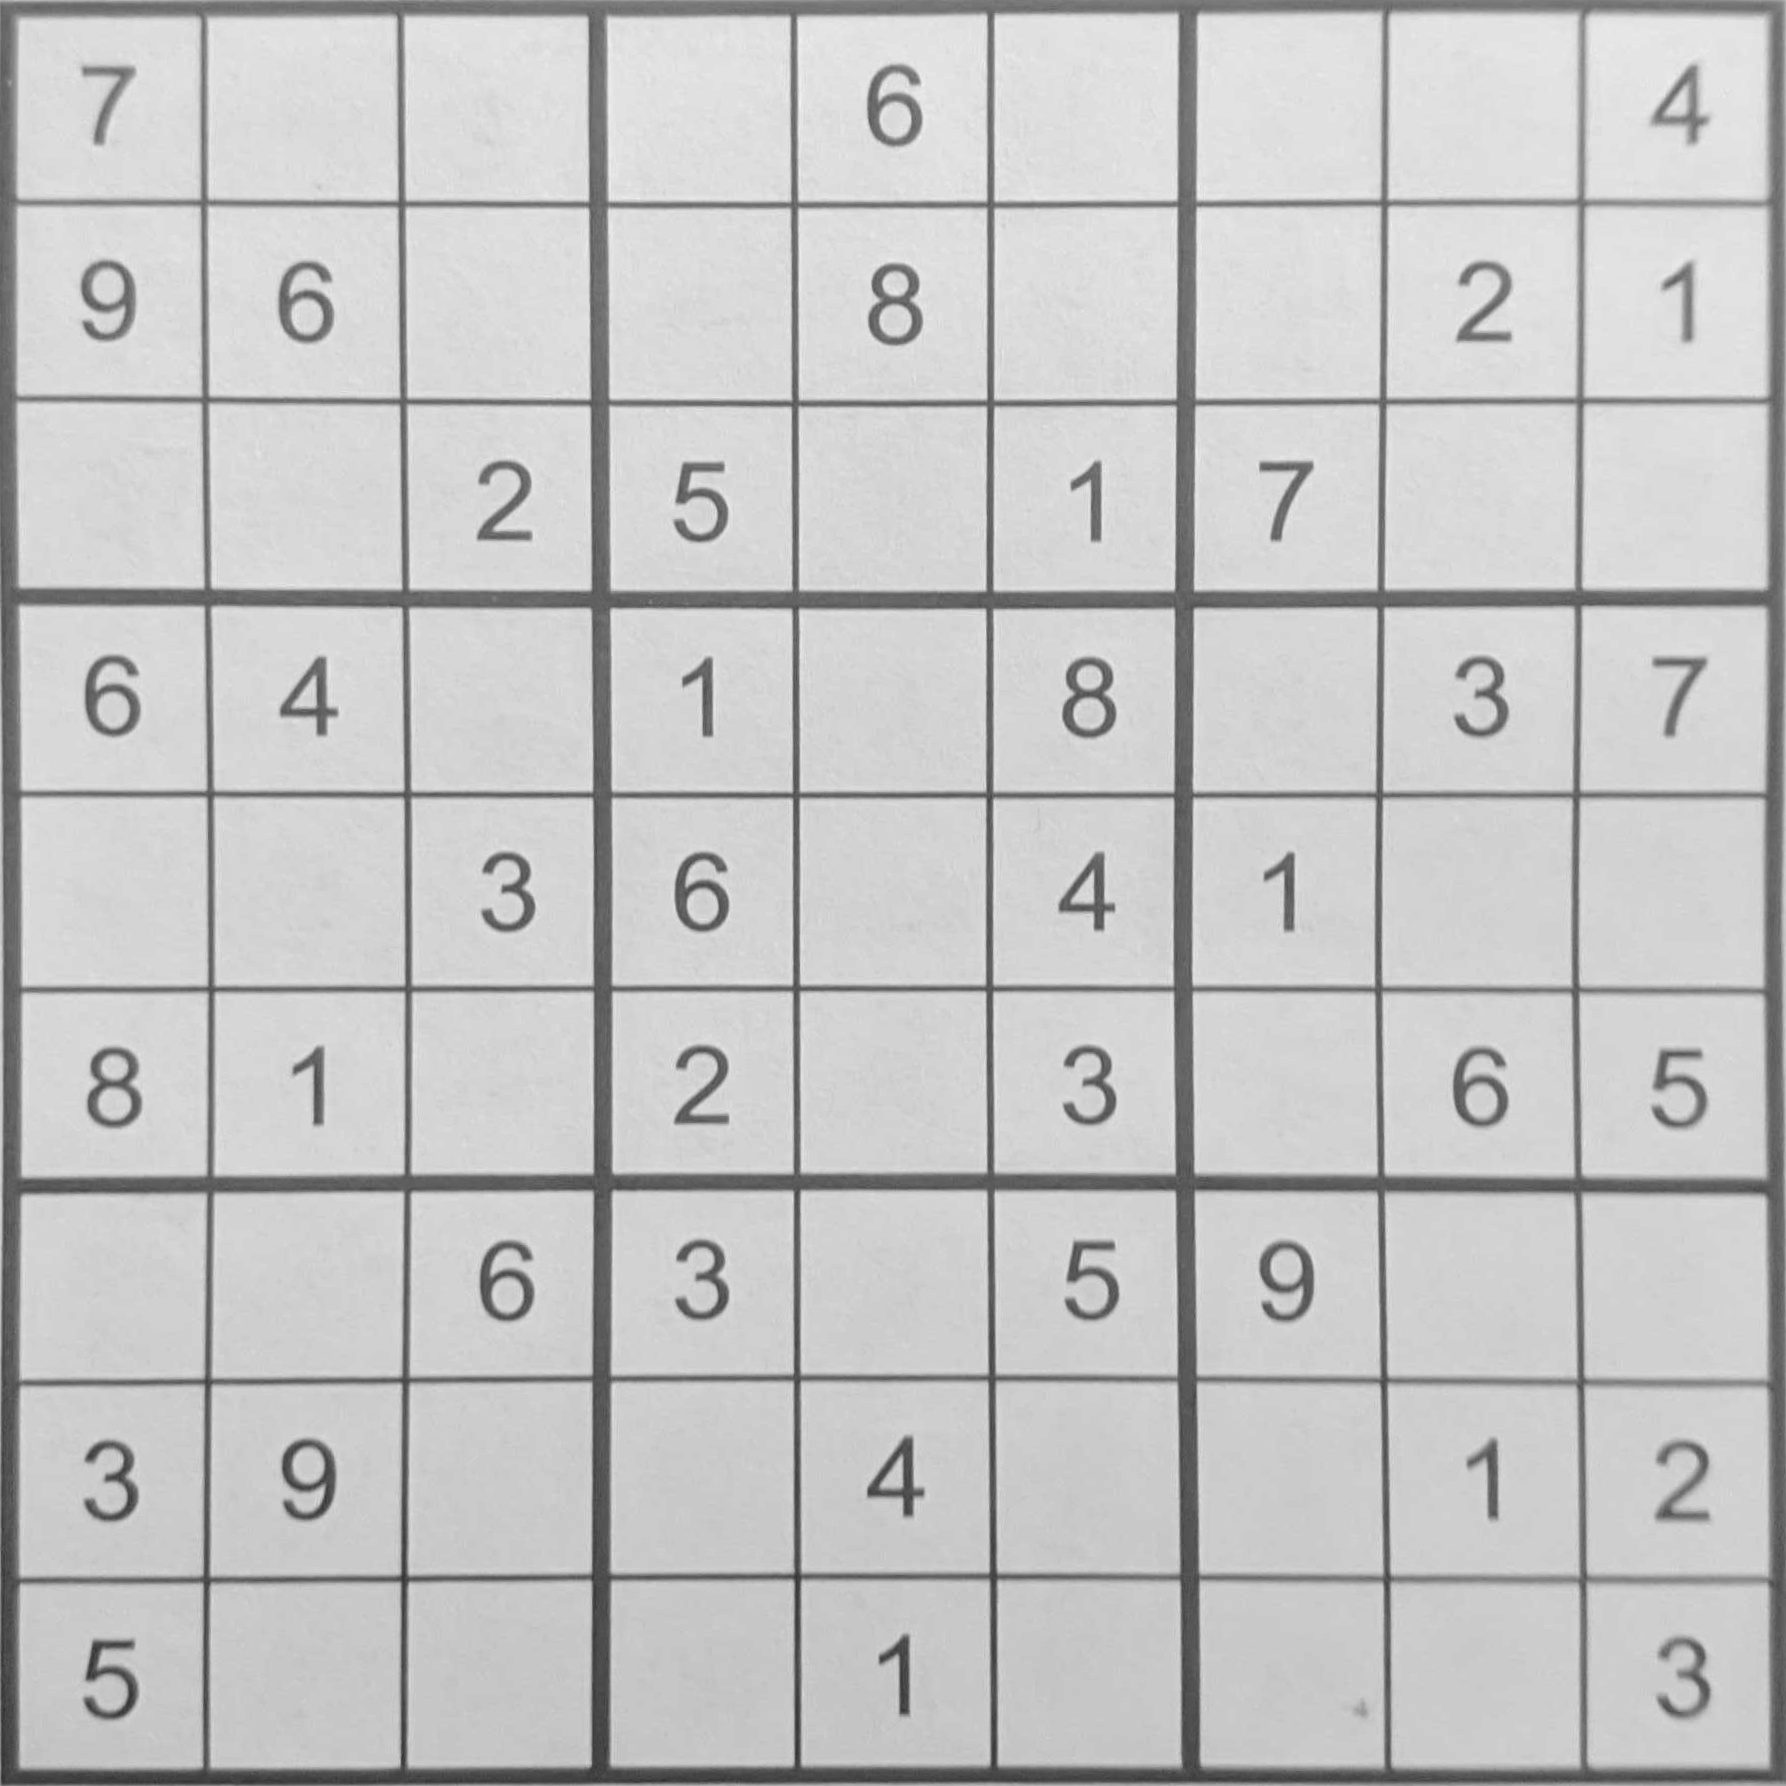

In [129]:
(Image(filename='./images/image_13.jpg'))

## Read in the image:

In [130]:
filename = './images/image_13.jpg'
img = cv2.imread(filename)

In [131]:
cv2.imshow("Image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

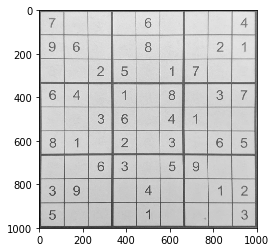

In [132]:
W = 1000
heigh, width, depth = img.shape
imgScale = W/width
newX, newY = img.shape[1]*imgScale, img.shape[0]*imgScale
new_img = cv2.resize(img, (int(newX), int(newY)))
cv2.imshow("Show by CV2", new_img)
cv2.waitKey(0)
cv2.imwrite('resize_white_img.png', new_img)
plt.imshow(new_img) 

In [ ]:
#invert_img = cv2.bitwise_not(new_img)
#cv2.imshow("invert1", invert_img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [133]:
new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)


In [134]:
thresh3 = cv2.adaptiveThreshold(new_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 5)


In [140]:
smooth_image = cv2.bilateralFilter(thresh3, 15, 25, 25)

In [141]:
cv2.imshow("smooth_image", smooth_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

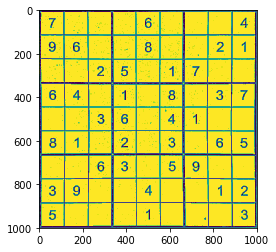

In [142]:
plt.imshow(smooth_img)

In [143]:
invert_img = cv2.bitwise_not(thresh3)

In [146]:
invert_img2 = cv2.bitwise_not(smooth_img)

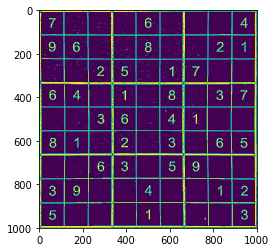

In [147]:
plt.imshow(invert_img2)

In [ ]:
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1, 9,-1],
                              [-1,-1,-1]])
# applying the sharpening kernel to the input image & displaying it.
sharpened = cv2.filter2D(invert_img, -1, kernel_sharpening)
cv2.imshow('Image Sharpening', sharpened)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# new_img = (cv2.threshold(sharpened, 125, 255, cv2.THRESH_BINARY))
#new_img1 = cv2.threshold(new_img, 200, 255, cv2.THRESH_BINARY)

In [ ]:
# invert_img1 = new_img[1]

In [ ]:
plt.imshow(sharpened)

In [148]:
rows = [(30,110), (125,205), (235,315), (350,430), (455,535), (580,660), (680,760), (785,865), (890,970)]
columns = [(30,110), (130,210), (240,320), (355,435), (455,535), (575,655), (680,760), (800,880),(890,970)]
images_list = []
for unit in rows:
    for units in columns:
        images_list.append(invert_img[unit[0]:unit[1], units[0]:units[1]])

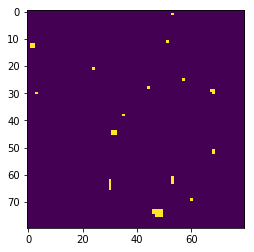

In [149]:
plt.imshow(images_list[1])

In [150]:
for i in range(len(images_list)):
    print(images_list[i].mean().round(2), images_list[i].min(), images_list[i].max())

16.02 0 255
1.55 0 255
1.55 0 255
1.0 0 255
26.1 0 255
0.72 0 255
0.28 0 255
0.12 0 255
18.81 0 255
25.3 0 255
25.82 0 255
1.24 0 255
1.67 0 255
26.18 0 255
2.11 0 255
0.96 0 255
21.2 0 255
12.87 0 255
1.51 0 255
1.0 0 255
21.83 0 255
23.43 0 255
1.71 0 255
14.74 0 255
16.14 0 255
0.24 0 255
0.08 0 255
24.82 0 255
20.12 0 255
0.72 0 255
14.02 0 255
0.68 0 255
25.7 0 255
0.72 0 255
20.2 0 255
14.9 0 255
0.28 0 255
1.2 0 255
21.12 0 255
24.78 0 255
1.12 0 255
19.96 0 255
13.95 0 255
0.08 0 255
0.0 0 0
26.7 0 255
16.34 0 255
7.41 0 255
30.68 0 255
10.2 0 255
27.17 0 255
5.98 0 255
24.94 0 255
21.16 0 255
0.48 0 255
0.4 0 255
24.15 0 255
20.52 0 255
0.32 0 255
21.64 0 255
23.91 0 255
0.16 0 255
0.04 0 255
20.12 0 255
23.87 0 255
0.24 0 255
0.28 0 255
19.28 0 255
0.04 0 255
0.12 0 255
12.99 0 255
19.92 0 255
21.0 0 255
0.16 0 255
0.16 0 255
0.28 0 255
12.19 0 255
0.0 0 0
0.32 0 255
0.0 0 0
19.64 0 255


In [ ]:
final_images = []
for i in range(len(images_list)):
    img_array = cv2.cvtColor(images_list[i], cv2.COLOR_BGR2GRAY)
    resize_img = cv2.resize(img_array, (28,28))
    final_images.append(resize_img)


In [ ]:
cntr_img= []

for i in range(len(final_images)):
    ret, thresh = cv2.threshold(final_images[i], 200, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(contours[0])
        crop = final_images[i][y:y+h, x:x+w]
        borderType = cv2.BORDER_CONSTANT
        top = int(0.35 * crop.shape[0])
        bottom = top
        left = int(0.35 * crop.shape[1])
        right = left
        border_img = cv2.copyMakeBorder(crop, top, bottom, left, right, borderType)
        border_img = cv2.resize(border_img, (28,28))
    cntr_img.append(border_img)


In [ ]:
plt.imshow(cntr_img[80])

In [ ]:
cntr_img[0].shape


gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5,5), 0)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

rows = [(15,125), (125,225), (235,335), (340,440), (455,555), (570,670), (680,780), (775,875), (890,990)]
columns = [(30,130), (130,230), (240,340), (355,455), (455,555), (565,665), (670,770), (800,900),(890,990)]
images_list = []
for unit in rows:
    for units in columns:
        images_list.append(thresh[unit[0]:unit[1], units[0]:units[1]])

In [ ]:
cnts = cv2.findContours(thresh[1].copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [ ]:

# loop over the contours
for c in cnts:
	# compute the center of the contour
	M = cv2.moments(c)
	cX = int(M["m10"] / M["m00"])
	cY = int(M["m01"] / M["m00"])
 
	# draw the contour and center of the shape on the image
	cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
	cv2.circle(image, (cX, cY), 7, (255, 255, 255), -1)
	cv2.putText(image, "center", (cX - 20, cY - 20),
		cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
 
	# show the image
	cv2.imshow("Image", image)
	cv2.waitKey(0)
# loop over the contours
# loop over the contours

for c in cnts:
    # compute the center of the contour
    M = cv2.moments(c)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0
    
    # cX = int(M["m10"] / M["m00"])
    # cY = int(M["m01"] / M["m00"])
 
    # draw the contour and center of the shape on the image
    cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
    cv2.circle(image, (cX, cY), 7, (255, 255, 255), -1)
    cv2.putText(image, "center", (cX - 20, cY - 20),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
 
    # show the image
    cv2.imshow("Image", image)
    cv2.waitKey(0)
# On Line 25 we start loopin

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5,5), 0)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

images_list = []
for unit in rows:
    for units in columns:
        images_list.append(invert_img[unit[0]:unit[1], units[0]:units[1]])

In [ ]:
plt.imshow(images_list[71])

In [ ]:
gray_image = cv2.cvtColor(final_images[71], cv2.COLOR_BGR2GRAY)
 
# convert the grayscale image to binary image
ret,thresh = cv2.threshold(gray_image,127,255,0)
 
# calculate moments of binary image
M = cv2.moments(thresh)
 
# calculate x,y coordinate of center
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
 
# put text and highlight the center
cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
cv2.putText(img, "centroid", (cX - 25, cY - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
 
# display the image
cv2.imshow("Image", img)
cv2.waitKey(0)

In [ ]:
cnts = cv2.findContours(final_images[71], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cnts = imutils.grab_contours(cnts)

### To save the inverted and preprocessed images to local folder:

In [ ]:
# for i in range(len(images_list)):
#    if i <= 9:
#        cv2.imwrite("0"+f"{i}_flip.png", images_list[i])
#    else:
#        cv2.imwrite(f"{i}_flip.png", images_list[i])

In [ ]:
# for i in range(len(images_list)):
#    cv2.imwrite(f"0{i}_flip.png", images_list[i])

# cv2.imwrite("flip_img81.png", images_list[80])

In [ ]:
# To pull in the images from the local folder, and prepare them to be passed onto the model:

In [ ]:
count_images = []
for i in range(len(images_list)):
        cnts = cv2.findContours(images_list[i].copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        digitCnts = []
        # loop over the digit area candidates
        for c in cnts:
            # compute the bounding box of the contour
            (x, y, w, h) = cv2.boundingRect(c)
            # if the contour is sufficiently large, it must be a digit
            if w >= 15 and (h >= 30 and h <= 40):
                digitCnts.append(c)
            
        count_images.append(digitCnts)

In [ ]:
final_images = []
for i in range(len(images_list)):
#    img_array = cv2.imread(os.path.join(IMG_DIR, images))
    img_array = cv2.cvtColor(images_list[i], cv2.COLOR_BGR2GRAY)
    
    resize_img = cv2.resize(img_array, (28,28))
    #new_img = cv2.threshold(resize_img, 115, 255, cv2.THRESH_BINARY)
    final_images.append(resize_img)

In [ ]:
plt.imshow(final_images[72]) # 47, 57, 69, 

In [ ]:
import imutils

In [ ]:
cv2.CHAIN_APPROX_NONE

In [ ]:
cnts = cv2.findContours(final_images[72].copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


In [ ]:
cnts = cv2.findContours(final_images[72].copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [ ]:
plt.imshow(final_images[72])

In [ ]:
# cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
# cnts = imutils.grab_contours(cnts)

for i in range(len(final_images)):
    
    cnts = cv2.findContours(final_images[i].copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    digitCnts = []
    for c in cnts:
        
        (x, y, w, h) = cv2.boundingRect(c)
        
        if w >= 15 and (h>= 30 and h <=40):
            
            digitCnts.append(c)


In [ ]:
def norm_digit(im):
    h, w = im.shape
    if h > w:
        top, left = round(h * 0.1), round((1.2 * h - w) / 2)
    else:
        top, left = round(w * 0.1), round((1.2 * w - h) / 2)

    return cv2.resize(
        cv2.copyMakeBorder(im, top, top, left, left, cv2.BORDER_CONSTANT), 
        (28, 28)
    )

In [ ]:
new_lst = []
for i in range(len(final_images)):
    new = norm_digit(final_images[i])
    new_lst.append(new)
    

In [ ]:
plt.imshow(new_lst[79])

In [ ]:
def get_one_contour(): 
    """Returns a 'fixed' contour""" 
    cnts = [np.array( [[[600, 320]], [[563, 460]], [[460, 562]], [[320, 600]], [[180, 563]], [[78, 460]], [[40, 320]], [[77, 180]], [[179, 78]], [[319, 40]], [[459, 77]], [[562, 179]]], dtype=np.int32)] 
    return cnts

In [ ]:
contours = get_one_contour()
print("'detected' contours: '{}' ".format(len(contours)))
print("contour shape: '{}'".format(contours[0].shape))

In [ ]:
type(digitCnts)

In [ ]:
digitCnts

In [ ]:
plt.imshow(digitCnts[0][0])

In [ ]:
        
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        cv2.drawContours(final_images[i], [c], -1, (0,255, 0), 2)
        cv2.circle(final_images[i], (cX, cY), 7, (255,255,255), -1)
        final_list = cv2.putText(final_images[i], "center", (cX -20, cY -20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        cv2.imshow("Image", final_images[i])
        cv2.waitKey(0)
    
    new_list.append(final_list)

In [ ]:
digitCnts = []
 
# loop over the digit area candidates
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
 
	# if the contour is sufficiently large, it must be a digit
	if w >= 15 and (h >= 30 and h <= 40):
		digitCnts.append(c)

In [ ]:
new_list= []
for i in range(len(final_images)):
    conts = cv2.findContours(final_images[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    new_list.append(conts)

In [ ]:
plt.imshow(new_list[0])

In [ ]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
digitCnts = []
 
# loop over the digit area candidates
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
 
	# if the contour is sufficiently large, it must be a digit
	if w >= 15 and (h >= 30 and h <= 40):
		digitCnts.append(c)

img_list = []
for i in range(len(final_images)):
    (cv2.threshold(final_images[i], 125, 255, cv2.THRESH_BINARY))

In [ ]:
plt.imshow(final_images[20])

In [ ]:
# img_change = cv2.threshold(final_images[78], 130, 255, cv2.THRESH_BINARY)
#plt.imshow(img_change)

In [ ]:
transform = transforms.ToTensor()
tensor_images = []
for images in final_images:
    tensors = torch.tensor(images, dtype=torch.float)
    tensor_images.append(tensors)

In [ ]:
plt.imshow(tensor_images[78])

# Let's predict

In [ ]:
model = torch.load('./results/model.pth')
model.eval()

## How to save?

In [ ]:
plt.imshow(np.full_like(final_images[5], 0))

In [ ]:
plt.imshow(final_images[59])

# Creating tuples

In [ ]:
plt.imshow(new_img)

In [ ]:
plt.imshow(final_images[23])

### Transform numpy arrays to tensors

In [ ]:
transform = transforms.ToTensor()

In [ ]:
tensors = []
for num in first_list:
    tensors.append((transform(num[0]).view(1,28,28).type(torch.FloatTensor), num[1]))
        
#    for i, b in num: #num represents the tuple itself
#        i = transform(i)
#        tensors.append((i,b))
#        transform(copy_img1_1[i][b])

In [ ]:
type(tensors)

In [ ]:
type(tensors[200])

In [ ]:
(tensors[203][0]).dtype

In [ ]:
len(tensors)

In [ ]:
tensors[20][0].shape # 1 is the number of images, 1 is the layers i.e. RGB vs Gray and 28*28 is the size

In [ ]:
# train_loader = (n for n in tensors)
# batch = next(iter(train_loader))
# images, labels = batch
# images, labels = batch


In [ ]:
train_loader = torch.utils.data.DataLoader(tensors, batch_size=10, shuffle=True)

In [ ]:
batch = next(iter(train_loader))
print('len:', len(batch))

In [ ]:
images, labels = batch

In [ ]:
print('Types:', type(images), type(labels))
print('shapes:', images.shape, labels.shape)


In [ ]:
labels

In [ ]:
import torchvision

In [ ]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15,15))
# plt.imshow(grid)
plt.imshow(np.transpose(grid, (1,2,0)))

print('labels:', labels)

In [ ]:
import helper

In [ ]:
# images, label = next(iter(train_loader))
helper.imshow(images[4,:]);

# Models

We will be creating a CNN to train our model.

In [ ]:
# Build our own network.

In [ ]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [ ]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

In [ ]:
train_loader = torch.utils.data.DataLoader(tensors, batch_size=10, shuffle=True)

In [ ]:
batch = next(iter(train_loader))
print('len:', len(batch))

In [ ]:
images, labels = batch

In [ ]:
print('Types:', type(images), type(labels))
print('shapes:', images.shape, labels.shape)


In [ ]:
labels

In [ ]:
preds = model(images) # Pass Batch
loss = F.cross_entropy(preds, labels) # Calculate Loss

loss.backward() # Calculate Gradients
optimizer.step() # Update Weights

print('loss1:', loss.item())
preds = model(images)
loss = F.cross_entropy(preds, labels)
print('loss2:', loss.item())

In [ ]:
network = ConvolutionalNetwork()
optimizer = optim.Adam(network.parameters(), lr=0.01)
train_loader = torch.utils.data.DataLoader(
    tensors
    ,batch_size=100
    ,shuffle=True
)

In [ ]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [ ]:
for epoch in range(50):

    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, labels = batch 

        preds = network(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

In [ ]:
images.shape

In [ ]:
model

In [ ]:
checkpoint = {'model': model,
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint1.pth')

In [ ]:
torch.save(model, 'model1.pth')

In [ ]:
torch.save(model.state_dict(), 'model1.pth')

In [ ]:
#the_model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load('model1.pth'))

# Making Predictions

In [ ]:
model

In [ ]:
transform = transforms.ToTensor()

In [ ]:
tensor_images = []
for images in final_images:
    tensors = torch.tensor(images, dtype=torch.float)
    tensor_images.append(tensors)

In [ ]:
model(tensor_images[79].view(1,1,28,28)).argmax()

In [ ]:
IMG_DIR = 'C:/Users/Billi/repos/sudoku/images/Square5'

In [ ]:
filenames = os.listdir(IMG_DIR)
#filenames.sort()
final_images1 = []
for images in filenames:
    img_array = cv2.imread(os.path.join(IMG_DIR, images))
#    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
#    resize_img = cv2.resize(img_array, (28,28))
    final_images1.append(img_array)

In [ ]:
#pred_tensor = []
#for num in final_images1:
#pred_tensor.append((transform(num[0]).view(1,28,28).type(torch.FloatTensor), num[1]))

In [ ]:
for i in range(len(final_images1)):
    if final_images1[i].max() != 255:
        np.full_like(final_images1[i], 0)

In [ ]:
plt.imshow(final_images1[4])

In [ ]:
final_images1[4].mean()

In [ ]:
transform = transforms.ToTensor()
tensor_images1 = []
for images in final_images1:
    tensors1 = torch.tensor(images, dtype=torch.float)
    tensor_images1.append(tensors1)

In [ ]:
tensor_images1[5].shape

In [ ]:
def convert(tensor): # always be passing in an array
    grid = []
    for i in range(len(tensor_images1)):
        if tensor[i].mean().item() <= 22:
            grid.append(".")
        else:
            grid.append(str(network(tensor[i]).argmax().item()))
    return grid

In [ ]:
convert(tensor_images1)

In [ ]:
len(tensors)

In [ ]:
optimizer = optim.Adam(network.parameters(), lr=0.01)

total_loss = 0
total_correct = 0

for batch in next(iter(train_loader)): # Get Batch
    images, labels = batch 

    preds = network(images) # Pass Batch
    loss = F.cross_entropy(preds, labels) # Calculate Loss

    optimizer.zero_grad()
    loss.backward() # Calculate Gradients
    optimizer.step() # Update Weights

    total_loss += loss.item()
#    total_correct += get_num_correct(preds, labels)
    
print(
    "epoch:", 0, 
#    "total_correct:", total_correct, 
    "loss:", total_loss
)

In [ ]:

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 25
for e in range(epochs):
    running_loss = 0
    for images, labels in next(iter(train_loader)):
        # Flatten MNIST images into a 784 long vector
        images = images.view(1,28,28).argmax()
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(train_loader)}")

In [ ]:
def convert(tensor): # always be passing in an array
    grid = []
    for i in range(len(tensor)):
        if tensor[i].mean().item() <= 22:
            grid.append(".")
        else:
            grid.append(str(model(tensor[i].view(1,1,28,28)).argmax().item()))
    return grid

In [ ]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [ ]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
#        if b%600 == 0:
#            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
#accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

In [ ]:

for i in range(len(final_images)):
    if final_images[i].max() != 255:
        np.full_like(final_images[i], 0)